# DoorDash ETA Prediction

In [1]:
import numpy as np # linear algebra
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

In [2]:
df_master = pd.read_csv('historical_data.csv')

In [3]:
df_master.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [4]:
df = df_master.copy()

# Data Preprocessing

Transformed raw data into a clean and analyzable format. Key steps include. Calculated the `delivery_time` by factoring out customer-driven durations. Derived additional features like day of the week, time of day, and month to capture temporal patterns. Handled categorical variables with high cardinality (e.g., consolidating low-frequency categories into "Other"). Derived metrics such as `%_dashers_avail` for operational insights. Cleaned the dataset by removing outliers in features like subtotal, delivery time, and item prices.

In [5]:
#MARK THIS AS TARGET VARIABLE
df['delivery_time'] = (pd.to_datetime(df['actual_delivery_time']) - pd.to_datetime(df['created_at'])).dt.total_seconds()
df['delivery_time'] = df['delivery_time'] - df['estimated_order_place_duration'] #<-- Customer driven so will factor this out

#CREATE SOME OTHER VARIABLES FOR ANALYSIS SUCH AS DAY, MONTH, HOUR
df['day_of_week_name'] = pd.to_datetime(df['created_at']).dt.day_name()
df['day_of_week_num'] = pd.to_datetime(df['created_at']).dt.dayofweek
df['month'] = pd.to_datetime(df['created_at']).dt.month
df['time'] = pd.to_datetime(df['created_at']).dt.hour

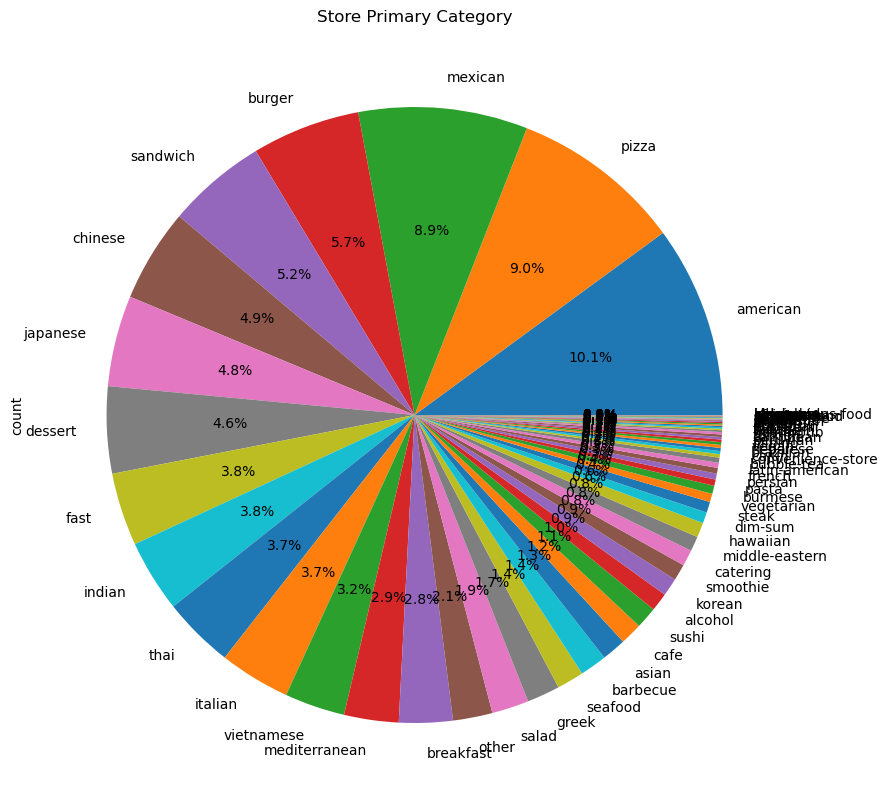

In [6]:
# Pie Chart on the store_primary_category

df['store_primary_category'].value_counts().plot.pie(autopct='%1.1f%%',figsize=(10,10))
plt.title('Store Primary Category')
plt.show()

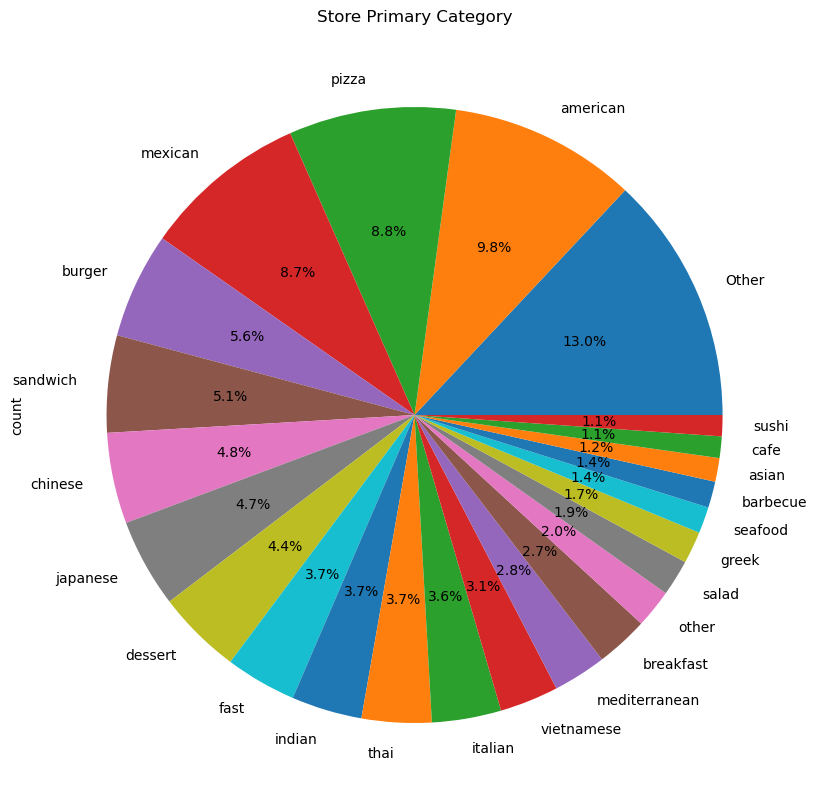

In [7]:
df_temp = df.copy()

# Calculate category frequencies
category_frequencies = df_temp['store_primary_category'].value_counts(normalize=True)

# Replace less frequent categories with 'Other' and handle NaN
df_temp['store_primary_category'] = df_temp['store_primary_category'].apply(
    lambda x: x if pd.notna(x) and category_frequencies.get(x, 0) > 0.01 else 'Other'
)

# Plot the pie chart
df_temp['store_primary_category'].value_counts().plot.pie(
    autopct='%1.1f%%', figsize=(10, 10)
)
plt.title('Store Primary Category')
plt.savefig('store_primary_category.png')

In [ ]:
#GOING TO CREATE A VALUE THAT SHOWS % of AVAILABLE DASHERS, IN SOME CASES BUSY > IS GREATER THAN TOTAL AVAILABLE
#SO I AM ASSUMING NO OVERLAP IN DRIVERS HERE. ALSO IN SOME CASES,  VALUE IS NEGATIVE AND I ASSUME THAT IS A DATA ERROR
df['total_busy_dashers'] = abs(df['total_busy_dashers'])
df['total_onshift_dashers'] = abs(df['total_onshift_dashers'])

#CREAT TOTAL BUSY DASHERS / TOTAL DASHERS
df['%_dashers_avail'] = df['total_busy_dashers']/(df['total_onshift_dashers'] +
                                                                      df['total_busy_dashers'])

In [ ]:
len_before_outliers = len(df)

def find_outliers(df, variable, distance):

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    df = df[(df[variable] > lower_boundary) &  (df[variable] < upper_boundary)]

    return df

#THERE ARE SOME VERY HIGH AND 0 SUBTOTALS, going to clean that up
df2 = find_outliers(df, 'subtotal', 1.5).sort_values(by = ['subtotal'])
df2 = find_outliers(df2, 'delivery_time', 1.5).sort_values(by = ['delivery_time'])
df2 = find_outliers(df2, 'max_item_price', 1.5).sort_values(by = ['delivery_time'])

print(f"Length Before Outliers: {len_before_outliers}")
print(f"Length after Outliers Dropped: {len(df2)}")

Length Before Outliers: 197428
Length after Outliers Dropped: 175587


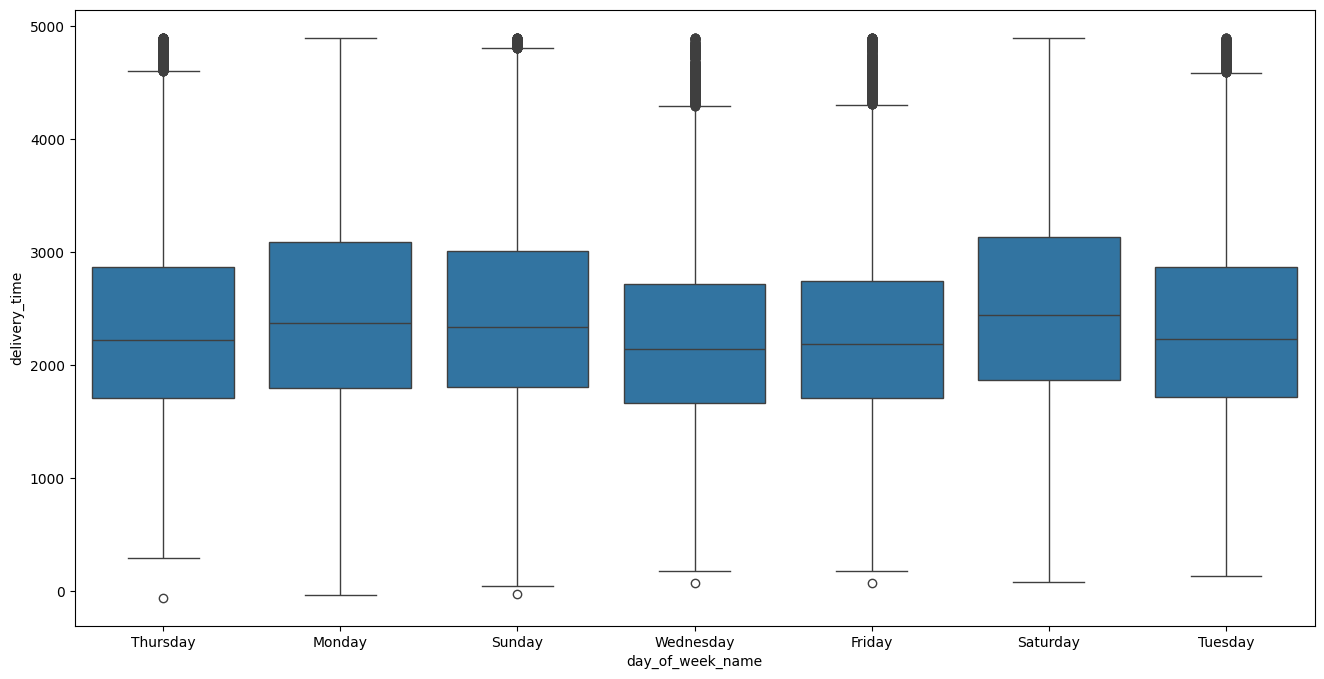

In [ ]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='day_of_week_name', y="delivery_time", data=df2)

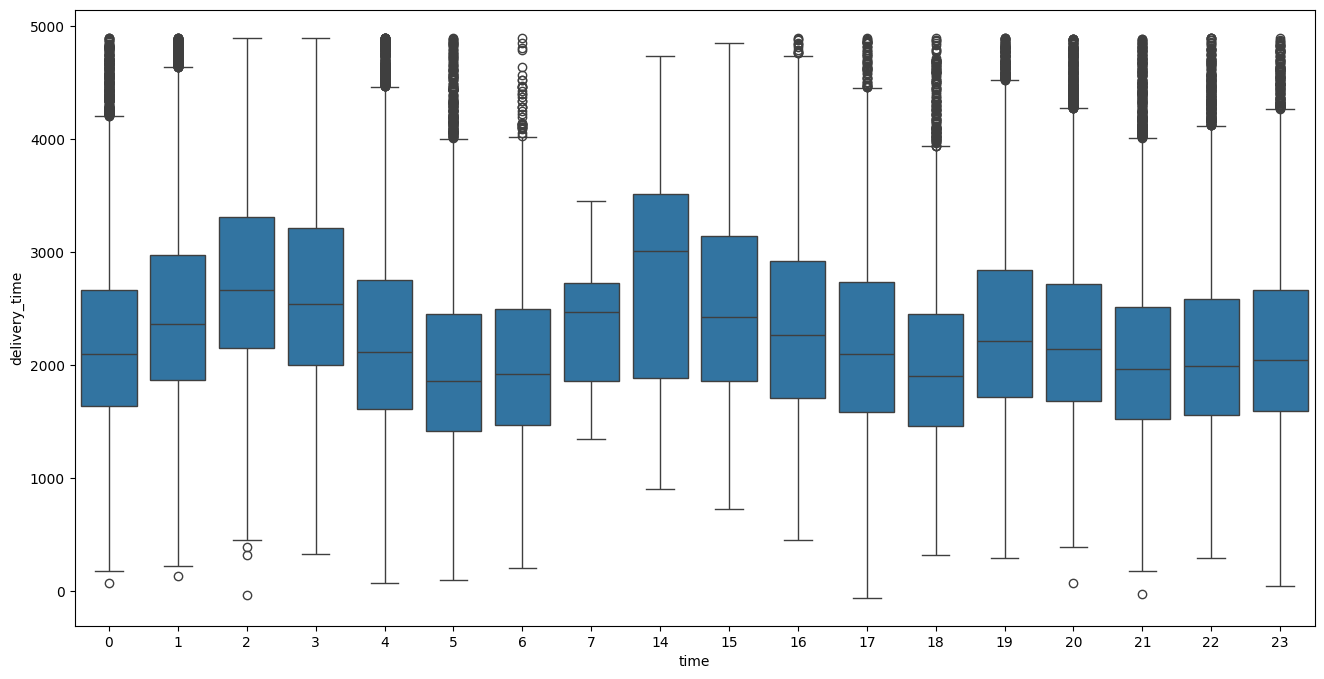

In [ ]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='time', y="delivery_time", data=df2)

#HIGHER MEDIAN DELIVERY TIMES at 2am and 2pm. Oddly no data for 8am - 1pm. 7am, 2pm and 3pm dont have
#outliers so it may be easier to predict those

# Variable Transformation

Feature transformation enhances model performance. Encoded categorical variables using label encoding for numerical representation. Dropped redundant or irrelevant features that may introduce noise or are highly correlated. Handled missing values to avoid errors during analysis. Visualized the correlation between variables with a heatmap to identify relationships and guide feature selection. Addressed multicollinearity by calculating Variance Inflation Factors (VIF) and dropping problematic features. This process prepared an optimized dataset for robust modeling.

In [ ]:
df_transform = df2.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', None)

le = LabelEncoder()

for cat_var in ['store_primary_category']:
    df_transform[cat_var] = le.fit_transform(df_transform[cat_var])

In [ ]:
#GOING TO DROP A FEW VARIABLES
df_transform = df_transform.drop(columns = ['created_at',  #<--- Referenced in dependent
                             'actual_delivery_time',   #<--- Referenced in dependent
                             'day_of_week_name'  #<-- Dummy created
                            ])

In [ ]:
#DROP NULLS
df_transform = df_transform.dropna(how='any',axis=0)

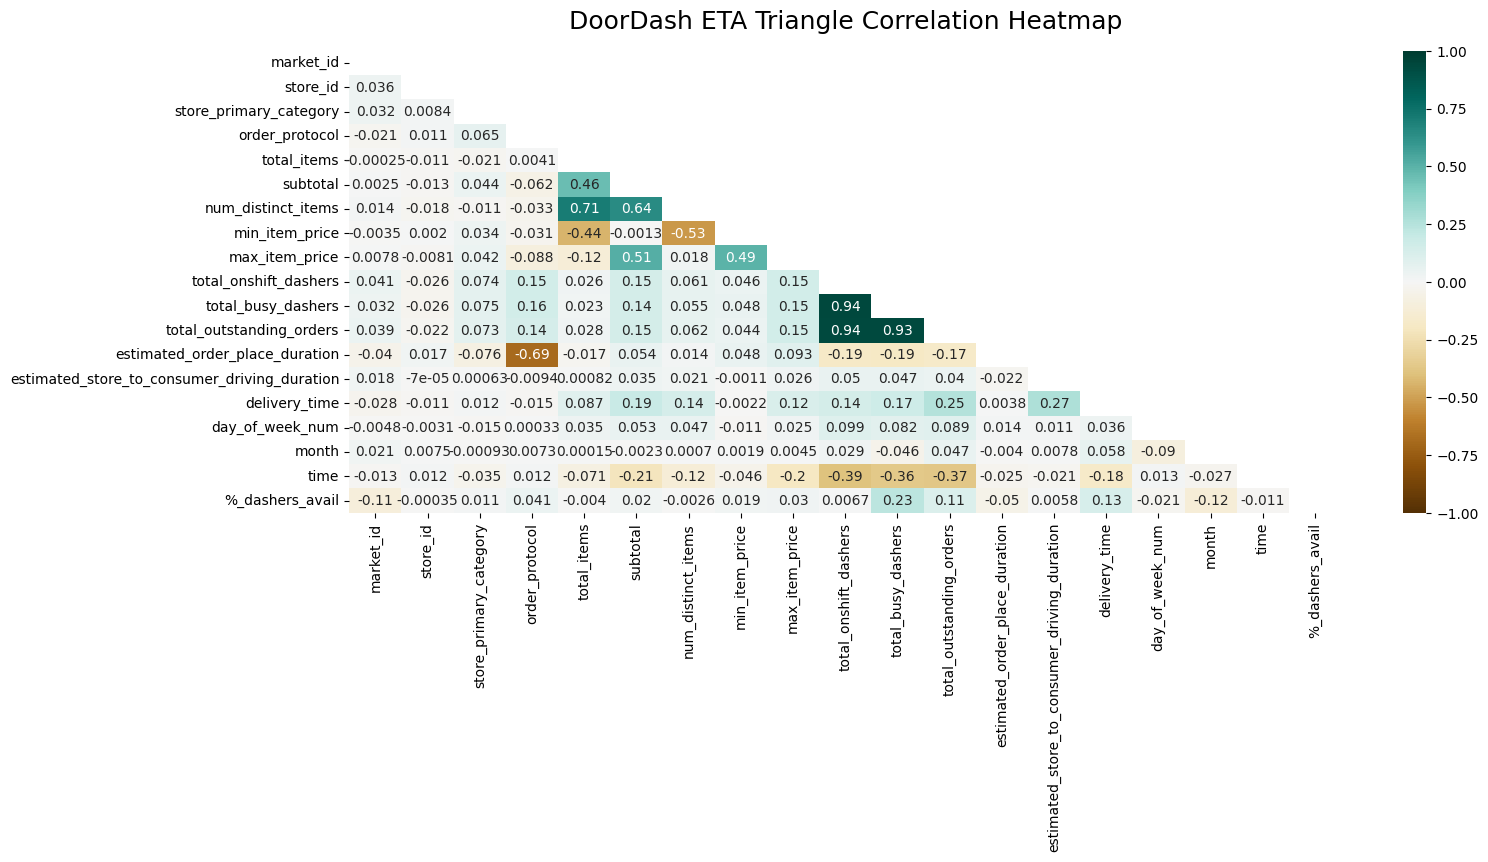

In [ ]:
corr_matrix = df_transform.corr(method='pearson')

#correlation map
f,ax = plt.subplots(figsize=(16, 6))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

heatmap = sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('DoorDash ETA Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);
plt.show()

In [ ]:
df_transform.columns

Index(['market_id', 'store_id', 'store_primary_category', 'order_protocol',
       'total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
       'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'delivery_time',
       'day_of_week_num', 'month', 'time', '%_dashers_avail'],
      dtype='object')

In [ ]:
#SOME COLUMNS ARE HIGHLY CORRELATED, GOING TO DROP A FEW:
df_transform = df_transform.drop(columns = ['min_item_price','num_distinct_items','order_protocol',
                                                               'total_onshift_dashers','total_busy_dashers','month'])

In [ ]:
vif_data = pd.DataFrame()
dependendent_df = df_transform.drop(columns = ['delivery_time'])

vif_data["feature"] = dependendent_df.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(dependendent_df.values, i)
                          for i in range(len(dependendent_df.columns))]

print(vif_data)

                                         feature        VIF
0                                      market_id   5.019235
1                                       store_id   3.872250
2                         store_primary_category   3.850372
3                                    total_items   3.997235
4                                       subtotal   9.645303
5                                 max_item_price  13.909240
6                       total_outstanding_orders   2.795805
7                 estimated_order_place_duration  11.174909
8   estimated_store_to_consumer_driving_duration   6.759276
9                                day_of_week_num   3.506158
10                                          time   2.339139
11                               %_dashers_avail  22.139042


In [ ]:
# Removing outliers with GMM
temp_df = df_transform.copy()

from sklearn.mixture import GaussianMixture
import numpy as np

# Assuming 'Delivery Time' is the column of interest
data = temp_df['delivery_time'].values.reshape(-1, 1)

# Fit GMM
gmm = GaussianMixture(n_components=1, random_state=0)  # Use 1 component for univariate data
gmm.fit(data)

# Compute probabilities
probabilities = gmm.score_samples(data)
threshold = np.percentile(probabilities, 2)  # Define threshold for outliers (e.g., 2nd percentile)

# Identify inliers
inliers = probabilities > threshold

# Filter out outliers
cleaned_df = temp_df[inliers]

print("Number of outliers removed:", len(temp_df) - len(cleaned_df))



Number of outliers removed: 3130


In [ ]:
# Number of outliers removed

print(f"Length Before Outliers: {len(df_master)}")
print(f"Length after Outliers Dropped: {len(cleaned_df)}")

Length Before Outliers: 197428
Length after Outliers Dropped: 153100


In [ ]:
# Save cleaned df

cleaned_df.to_csv('cleaned_data.csv', index=False)

In [17]:
# Extract cleaned data

cleaned_df = pd.read_csv('cleaned_data.csv')

# Regression Testing

Evaluated regression models to predict delivery times. Split the cleaned and transformed dataset into training and testing sets. Tested multiple regression techniques for performance comparison. Calculated error metrics to assess model accuracy. Selected features with high predictive value while excluding highly correlated variables to avoid overfitting. Identified the best-performing model for the ETA prediction task.

In [18]:
import time
MSE = {}
Time = {}

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute
from sklearn.metrics import mean_absolute_percentage_error

# Split data
X = cleaned_df.drop(columns=['delivery_time'])
y = cleaned_df['delivery_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Ridge Regression
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
start_time = time.perf_counter()
ridge.fit(X_train, y_train)
end_time = time.perf_counter()
y_pred = ridge.predict(X_test)
MSE['Ridge'] = mean_squared_error(y_test, y_pred)
Time['Ridge'] = end_time - start_time


In [ ]:
# Polynomial Regression degree 2
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
start_time = time.perf_counter()
poly = PolynomialFeatures(degree=2)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)
poly.fit(poly_X_train, y_train)
lin2 = Ridge()
lin2.fit(poly_X_train, y_train)
end_time = time.perf_counter()
y_pred = lin2.predict(poly_X_test)
MSE['Polynomial_2'] = mean_squared_error(y_test, y_pred)
Time['Polynomial_2'] = end_time - start_time

# Polynomial Regression degree 3
start_time = time.perf_counter()
poly = PolynomialFeatures(degree=3)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)
poly.fit(poly_X_train, y_train)
lin3 = Ridge()
lin3.fit(poly_X_train, y_train)
end_time = time.perf_counter()
y_pred = lin3.predict(poly_X_test)
MSE['Polynomial_3'] = mean_squared_error(y_test, y_pred)
Time['Polynomial_3'] = end_time - start_time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.27057e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.17706e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [ ]:
### DO NOT RUN THIS CELL

# Polynomial Regression degree 4
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
start_time = time.perf_counter()
poly = PolynomialFeatures(degree=4)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)
poly.fit(poly_X_train, y_train)
lin2 = Ridge()
lin2.fit(poly_X_train, y_train)
end_time = time.perf_counter()
y_pred = lin2.predict(poly_X_test)
MSE['Polynomial_4'] = mean_squared_error(y_test, y_pred)
Time['Polynomial_4'] = end_time - start_time

# Polynomial Regression degree 5
start_time = time.perf_counter()
poly = PolynomialFeatures(degree=5)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)
poly.fit(poly_X_train, y_train)
lin3 = Ridge()
lin3.fit(poly_X_train, y_train)
end_time = time.perf_counter()
y_pred = lin3.predict(poly_X_test)
MSE['Polynomial_5'] = mean_squared_error(y_test, y_pred)
Time['Polynomial_5'] = end_time - start_time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.67082e-36): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [ ]:
# Support Vector Regression
from sklearn.svm import SVR
start_time = time.perf_counter()
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
end_time = time.perf_counter()
y_pred = svr.predict(X_test)
MSE['SVR'] = mean_squared_error(y_test, y_pred)
Time['SVR'] = end_time - start_time

In [19]:
# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor
start_time = time.perf_counter()
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
end_time = time.perf_counter()
y_pred = dt.predict(X_test)
MSE['Decision Tree'] = mean_squared_error(y_test, y_pred)
Time['Decision Tree'] = end_time - start_time

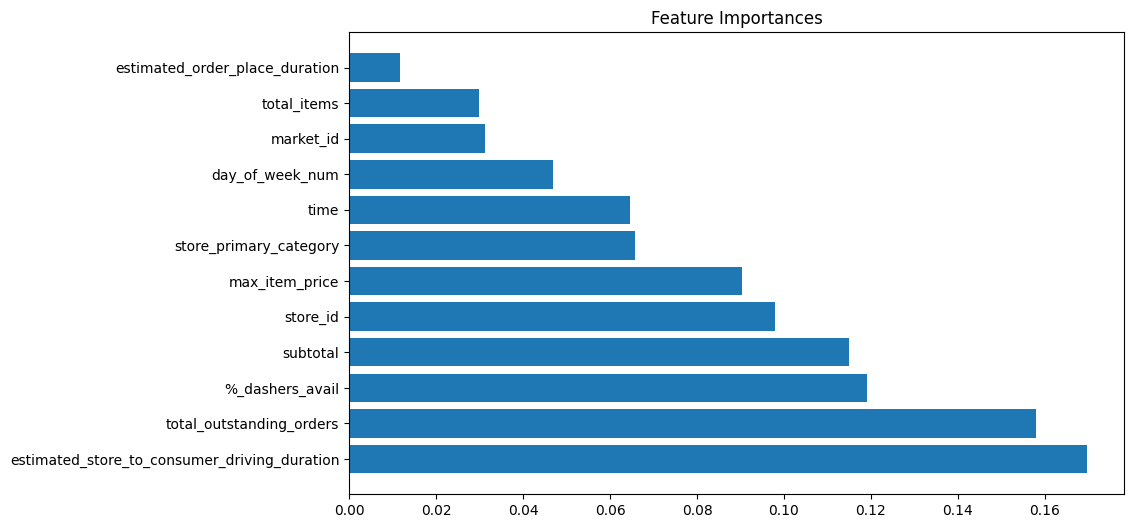

In [30]:
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns.tolist()

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), np.array(feature_names)[indices])
plt.show()


In [ ]:
# Implement Forest Regressor
# Train model
model = RandomForestRegressor(random_state=42)

start_time = time.perf_counter()
model.fit(X_train, y_train)
end_time = time.perf_counter()
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Random Forest Root MSE: {mse**0.5}")
MSE['random_forest'] = mse
Time['random_forest'] = end_time - start_time


Random Forest Root MSE: 697.8245784537798


In [ ]:
%pip install dask catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.3 MB/s eta 0:00:00


In [ ]:
## Boosting algorithms
# Gradient, XGBoost, LightGBM, CatBoost, AdaBoost

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
# Gradient Boosting
model = GradientBoostingRegressor(random_state=42)
start_time = time.perf_counter()
model.fit(X_train, y_train)
end_time = time.perf_counter()
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Gradient Boosting Root Mean Squared Error: {mse**0.5}')
MSE['gradient_boosting'] = mse
Time['gradient_boosting'] = end_time - start_time

Gradient Boosting Root Mean Squared Error: 700.3005491351146


In [ ]:
# XGBoost
model = XGBRegressor(random_state=42)
start_time = time.perf_counter()
model.fit(X_train, y_train)
end_time = time.perf_counter()
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'XGBoost Root Mean Squared Error: {mse**0.5}')
MSE['xgboost'] = mse
Time['xgboost'] = end_time - start_time


XGBoost Root Mean Squared Error: 674.7696561530144


In [ ]:
# LightGBM
model = LGBMRegressor(random_state=42)
start_time = time.perf_counter()
model.fit(X_train, y_train)
end_time = time.perf_counter()
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'LightGBM Root Mean Squared Error: {mse**0.5}')
MSE['lightgbm'] = mse
Time['lightgbm'] = end_time - start_time

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1690
[LightGBM] [Info] Number of data points in the train set: 122480, number of used features: 12
[LightGBM] [Info] Start training from score 2340.684855
LightGBM Root Mean Squared Error: 682.1076295759041


In [ ]:
# CatBoost
model = CatBoostRegressor(random_state=42, verbose=0)
start_time = time.perf_counter()
model.fit(X_train, y_train)
end_time = time.perf_counter()
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'CatBoost Root Mean Squared Error: {mse**0.5}')
MSE['catboost'] = mse
Time['catboost'] = end_time - start_time

CatBoost Root Mean Squared Error: 670.2249909049176


In [ ]:
# AdaBoost
model = AdaBoostRegressor(random_state=42)
start_time = time.perf_counter()
model.fit(X_train, y_train)
end_time = time.perf_counter()
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'AdaBoost Root Mean Squared Error: {mse**0.5}')
MSE['adaboost'] = mse
Time['adaboost'] = end_time - start_time


AdaBoost Root Mean Squared Error: 745.4385277512225


In [ ]:
# Save MSE and Time
import json

with open('MSE.json', 'w') as f:
    json.dump(MSE, f)

with open('Time.json', 'w') as f:
    json.dump(Time, f)

In [ ]:
import json

with open('MSE.json', 'r') as f:
    MSE = json.load(f)

with open('Time.json', 'r') as f:
    Time = json.load(f)

In [ ]:
# Print all MSE and Time in alphabetical order of keys

print('RMSE')

for key in sorted(MSE.keys()):
    print(f'{key} RMSE: {MSE[key] ** 0.5 / 60:.3f} minutes')

print('\nTime')

for key in sorted(Time.keys()):
    print(f'{key} Time: {Time[key]:.3f} seconds')


MSE_temp = MSE.copy()
Time_temp = Time.copy()
del Time_temp["Polynomial_5"]
del MSE_temp["Polynomial_5"]

RMSE
Decision Tree RMSE: 16.570 minutes
Polynomial_2 RMSE: 12.098 minutes
Polynomial_3 RMSE: 11.957 minutes
Polynomial_4 RMSE: 20.013 minutes
Polynomial_5 RMSE: 54974.603 minutes
Ridge RMSE: 12.279 minutes
SVR RMSE: 13.067 minutes
adaboost RMSE: 12.424 minutes
catboost RMSE: 11.170 minutes
gradient_boosting RMSE: 11.672 minutes
lightgbm RMSE: 11.368 minutes
random_forest RMSE: 11.630 minutes
xgboost RMSE: 11.246 minutes

Time
Decision Tree Time: 1.017 seconds
Polynomial_2 Time: 0.219 seconds
Polynomial_3 Time: 0.948 seconds
Polynomial_4 Time: 11.190 seconds
Polynomial_5 Time: 163.204 seconds
Ridge Time: 0.042 seconds
SVR Time: 371.238 seconds
adaboost Time: 3.262 seconds
catboost Time: 5.212 seconds
gradient_boosting Time: 14.015 seconds
lightgbm Time: 0.261 seconds
random_forest Time: 65.492 seconds
xgboost Time: 0.257 seconds


# Data Visual Analysis

Provided insights into data distribution and relationships. Performed certain transformations on the variables to be plotted to provide visually pleasing and easily understandable plots. By doing some visual analysis we determined the optimal model to be used for the task.

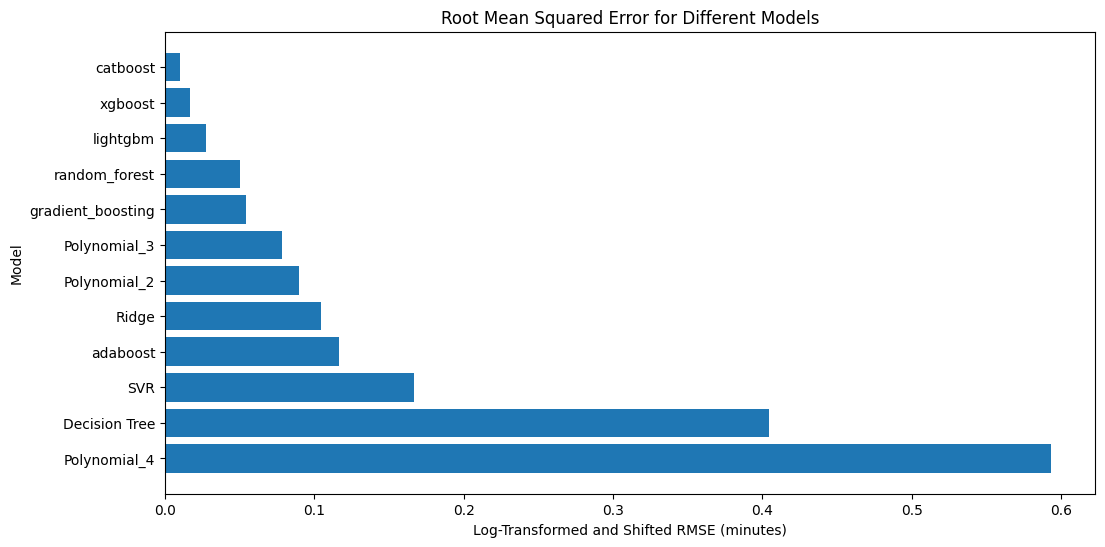

In [ ]:
# Plot RMSE/60 vs Model

RMSE_keys = list(MSE_temp.keys())
RMSE_vals = [np.sqrt(mse) / 60 for mse in MSE_temp.values()]

RMSE_keys = np.array(RMSE_keys)
RMSE_vals = np.array(RMSE_vals)

RMSE_vals = np.log(RMSE_vals)
RMSE_vals -= np.min(RMSE_vals) - 10e-3

sorted_idx = np.argsort(RMSE_vals)[::-1]
sorted_RMSE_keys = RMSE_keys[sorted_idx]
sorted_RMSE_vals = RMSE_vals[sorted_idx]

plt.figure(figsize=(12, 6))
plt.barh(sorted_RMSE_keys, sorted_RMSE_vals)

plt.xlabel('Log-Transformed and Shifted RMSE (minutes)')
plt.ylabel('Model')
plt.title('Root Mean Squared Error for Different Models')
plt.show()

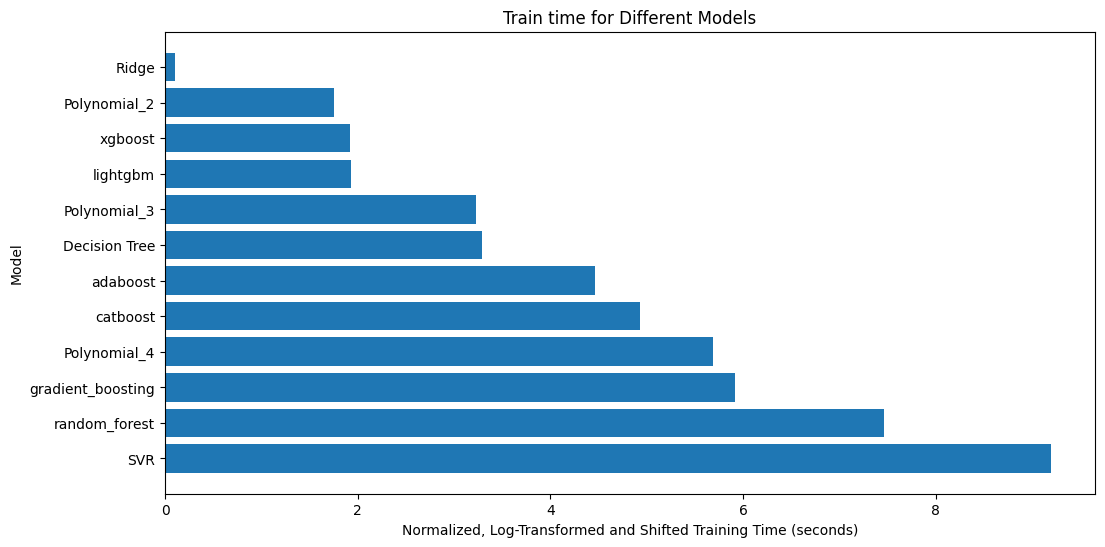

In [ ]:
# Plot Time vs Model

Time_keys = list(Time_temp.keys())
Time_vals = [time for time in Time_temp.values()]

Time_keys = np.array(Time_keys)
Time_vals = np.array(Time_vals)

Time_vals /= np.max(Time_vals)
Time_vals = -np.log(Time_vals)
Time_vals = np.max(Time_vals) + 10e-2 - Time_vals

sorted_idx = np.argsort(-Time_vals)
sorted_Time_keys = Time_keys[sorted_idx]
sorted_Time_vals = Time_vals[sorted_idx]

plt.figure(figsize=(12, 6))
plt.barh(sorted_Time_keys, sorted_Time_vals)
# plt.bar_label(plt.gca().containers[0])
plt.xlabel('Normalized, Log-Transformed and Shifted Training Time (seconds)')
plt.ylabel('Model')
plt.title('Train time for Different Models')
plt.show()

In [ ]:
rmse_weight = 0.7
time_weight = 0.3

# Normalize RMSE and time
normalized_rmse = np.exp(RMSE_vals) / np.sum(np.exp(RMSE_vals))
normalized_time = np.exp(Time_vals) / np.sum(np.exp(Time_vals))

complexity_scores = {
    model: rmse_weight * normalized_rmse[i] + time_weight * normalized_time[i]
    for i, model in enumerate(RMSE_keys)
}

sorted_complexity = dict(sorted(complexity_scores.items(),
                                key=lambda item: item[1],
                                reverse=True))
complexity = 1 / np.array(list(sorted_complexity.values()))

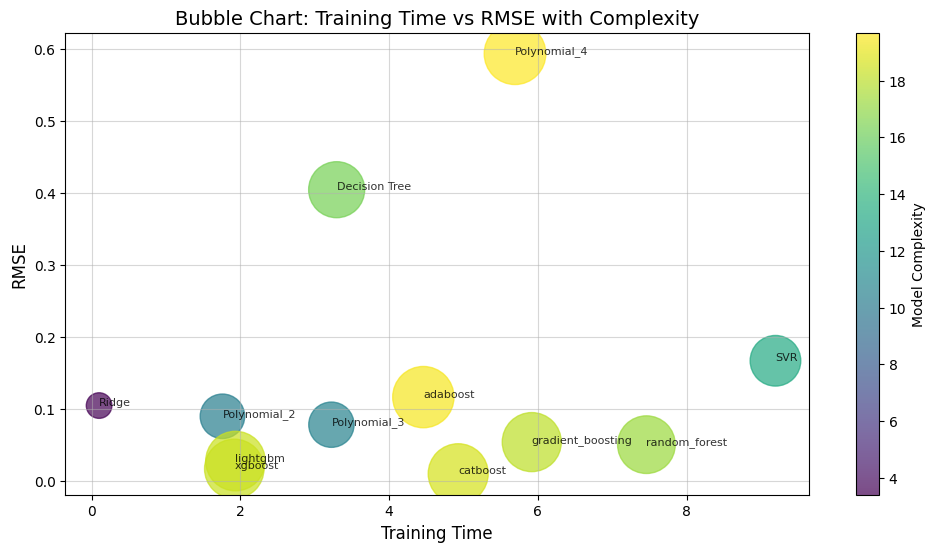

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(Time_vals, RMSE_vals,
            s=complexity * 100, alpha=0.7,
            c=complexity, cmap='viridis')

for i, model in enumerate(Time_keys):
    plt.annotate(model, (Time_vals[i], RMSE_vals[i]),
                 fontsize=8, alpha=0.8)

plt.colorbar(label='Model Complexity')
plt.title('Bubble Chart: Training Time vs RMSE with Complexity', fontsize=14)
plt.xlabel('Training Time', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(True, alpha=0.5)
plt.show()